<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
%pip install matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

Note: you may need to restart the kernel to use updated packages.


In [41]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import math
import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import typing
import numpy.typing as np_typing

##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafiles"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
train_df: np.ndarray = np.load(DATASET_FILE_PATH)
# TODO delete this when we fix performance
train_df = train_df[:min(1000000, train_df.size)]

In [43]:
#Define the splitter lambda function in order to tokenize the initial string data.
splitter = lambda s: s.split(",")
#Apply the splitter lambda function on the string np array
train_df = np.array([splitter(x) for x in train_df])
#Set the pickle file for storing the initial dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
#Check the existence of the specified file.
if os.path.exists(pickle_file):
    #Load the pickle file
    dataframe = pd.read_pickle(pickle_file)
else:
    #Create the dataframe object.
    dataframe = pd.DataFrame(train_df, columns=['User','Movie','Rating','Date'])
    #Convert the string elements of the "Users" series into integers
    dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
    #Convert the string elements of the "Movies" series into integers
    dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
    #Convert the string elements of the "Ratings" series into integers
    dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
    #Convert the string element of "Dates" series into datetime Object
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    dataframe.to_pickle(pickle_file)

In [44]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 355343 number of unique users and 118274 of unique movies
INITIAL DATASET: 1000000 total number of existing ratings


In [45]:
#Define the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file):
    #Load the pickle file
    ratings_num_df = pd.read_pickle(pickle_file)
else:
    ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
    #Save the previously created dataframe to pickle
    ratings_num_df.to_pickle(pickle_file)

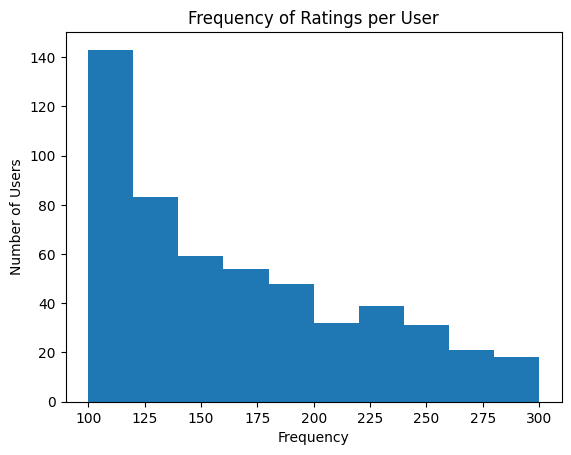

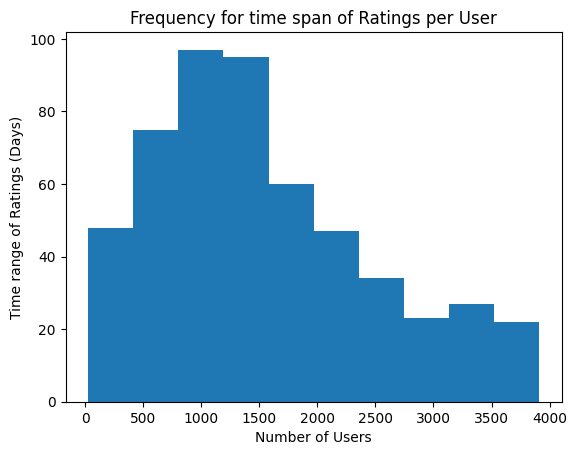

In [46]:
#Set the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
if os.path.exists(pickle_file):
    ratings_span_df = pd.read_pickle(pickle_file)
else:
    ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
    ratings_span_df.to_pickle(pickle_file)
#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

#Generate the frequency histogram for the number of ratings per user
reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
plt.xlabel('Frequency')
plt.ylabel('Number of Users')

plt.show()
#Generate the frequency histogram for the time span of ratings per user
reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
plt.xlabel('Number of Users')
plt.ylabel('Time range of Ratings (Days)')

plt.show()



                                                                                    

In [47]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 528 number of unique users and 29635 number of unique movies
REDUCED DATASET: 87686 number of existing ratings in the dataset


In [48]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [49]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [50]:
W

array([[1.        , 0.00982801, 0.00645161, ..., 0.        , 0.        ,
        0.04229607],
       [0.00982801, 1.        , 0.0126183 , ..., 0.        , 0.        ,
        0.00854701],
       [0.00645161, 0.0126183 , 1.        , ..., 0.        , 0.        ,
        0.00393701],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.0513834 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04229607, 0.00854701, 0.00393701, ..., 0.0513834 , 0.        ,
        1.        ]])

In [51]:
CommonRatings

array([[201.,   4.,   2., ...,   0.,   0.,  14.],
       [  4., 210.,   4., ...,   0.,   0.,   3.],
       [  2.,   4., 111., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ..., 122.,   0.,  13.],
       [  0.,   0.,   0., ...,   0., 109.,   0.],
       [ 14.,   3.,   1., ...,  13.,   0., 144.]])

In [52]:
final_df

,User,Movie,Rating,Date
0,313,9972,10,2005-01-16
1,203,6243,2,2005-01-16
2,203,10103,2,2005-01-16
3,25,14694,7,2005-01-16
4,25,18942,3,2005-01-16
...,...,...,...,...
87681,115,14341,9,2001-06-29
87682,89,14342,4,2001-05-06
87683,116,14342,8,2001-09-05
87684,51,14343,9,1999-08-28


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [53]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [54]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [56]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [57]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [58]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [59]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [60]:
# Calculate the pairwise weighted Euclidean distance matrix
# Calculate the pairwise weighted Euclidean distance matrix

def create_euclidean_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "euclidean_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_euclidean: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_euclidean
    else:
        n = ratings_matrix.shape[0]
        Dist_euclidean = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
                Dist_euclidean[i,j] = d
                Dist_euclidean[j,i] = d
        np.save(npy_file, Dist_euclidean, allow_pickle=True, fix_imports=True)
        return Dist_euclidean


Dist_euclidean = create_euclidean_distance_matrix_cached(ratings_matrix, binary_matrix)
Dist_euclidean

array([[ 0.        ,  3.60555128,  3.60555128, ...,  0.        ,
         0.        , 11.66190379],
       [ 3.60555128,  0.        ,  4.69041576, ...,  0.        ,
         0.        ,  3.        ],
       [ 3.60555128,  4.69041576,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  8.54400375],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.66190379,  3.        ,  1.        , ...,  8.54400375,
         0.        ,  0.        ]])

In [61]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,0.000000,3.605551,3.605551,9.273618,4.123106,2.828427,3.162278,5.000000,4.000000,2.00000,...,2.236068,7.549834,2.645751,8.831761,14.247807,4.898979,6.480741,0.000000,0.0,11.661904
1,3.605551,0.000000,4.690416,6.403124,5.744563,3.000000,5.099020,2.236068,2.449490,0.00000,...,4.123106,2.449490,3.000000,3.000000,6.000000,3.000000,3.162278,0.000000,0.0,3.000000
2,3.605551,4.690416,0.000000,6.557439,6.708204,0.000000,1.000000,3.162278,0.000000,0.00000,...,3.162278,3.605551,5.099020,8.000000,18.466185,4.795832,10.723805,0.000000,0.0,1.000000
3,9.273618,6.403124,6.557439,0.000000,7.000000,3.000000,3.000000,8.485281,0.000000,0.00000,...,6.244998,14.764823,6.928203,12.409674,30.675723,12.165525,18.275667,4.000000,1.0,16.248077
4,4.123106,5.744563,6.708204,7.000000,0.000000,5.385165,7.000000,8.544004,10.535654,5.09902,...,3.605551,10.770330,7.745967,7.416198,12.767145,6.164414,2.236068,0.000000,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,4.898979,3.000000,4.795832,12.165525,6.164414,3.605551,2.000000,4.582576,0.000000,0.00000,...,4.690416,8.660254,8.602325,8.831761,28.583212,0.000000,11.618950,1.414214,0.0,13.228757
524,6.480741,3.162278,10.723805,18.275667,2.236068,0.000000,0.000000,4.242641,1.000000,0.00000,...,3.316625,10.535654,13.228757,8.602325,18.654758,11.618950,0.000000,2.000000,6.0,12.609520
525,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.00000,...,0.000000,7.071068,1.000000,0.000000,13.152946,1.414214,2.000000,0.000000,0.0,8.544004
526,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0,0.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [62]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 0 0 3 1 0 0 1 2 2 0 2 2 2 0 2 2 2 4 2 4 2 2 4 0 3 1 4 0 2 2 2 2 4 1 1 0
 2 0 2 1 0 1 2 2 0 0 0 2 0 2 3 2 2 2 4 0 1 0 2 2 4 1 4 1 0 2 2 1 0 3 1 0 4
 2 3 3 2 2 2 0 0 4 4 2 4 4 2 3 0 4 4 2 4 2 4 0 4 4 0 0 0 3 4 2 1 2 3 2 0 2
 2 3 2 1 0 0 1 0 1 0 0 2 4 2 3 0 3 4 1 1 0 3 3 2 2 0 0 0 2 4 0 3 0 2 4 4 4
 1 1 2 4 0 4 0 4 3 4 1 2 4 1 2 2 1 0 4 0 3 4 1 4 1 0 2 1 0 3 2 3 2 3 1 2 0
 2 0 3 2 3 2 3 4 1 2 4 4 4 0 1 0 2 2 0 2 4 0 3 4 1 0 1 4 0 0 1 3 2 2 1 1 4
 3 2 0 2 4 0 3 2 0 3 0 0 1 2 2 0 0 0 2 2 0 4 0 1 2 3 1 2 4 4 1 1 4 1 0 4 1
 0 1 2 2 4 0 0 2 2 0 3 4 4 0 1 0 1 0 1 2 3 1 2 1 1 4 4 2 0 0 2 4 2 4 4 0 2
 0 0 3 2 0 2 4 0 0 1 0 0 2 0 4 2 4 0 0 0 4 4 2 1 2 4 3 2 2 3 0 4 4 1 3 2 4
 1 2 0 4 2 0 4 4 3 2 0 4 0 2 4 0 4 0 3 1 4 0 0 2 4 0 0 3 0 2 4 0 0 1 4 1 0
 1 2 4 4 4 0 2 1 4 4 2 2 2 2 0 4 0 0 3 1 2 1 0 0 1 4 4 3 3 1 1 3 0 0 1 1 0
 3 1 4 2 3 3 4 1 0 4 1 0 0 1 3 1 2 1 1 4 1 2 3 2 0 4 1 0 1 2 1 4 2 0 3 3 1
 1 2 4 2 1 2 2 1 2 0 0 3 2 4 1 2 4 4 2 2 0 2 4 3 3 0 4 2 3 2 3 0 1 1 4 1 4
 0 0 0 0 1 2 1 4 4 4 1 0 

Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [63]:
# Calculate the pairwise weighted Cosine distance matrix

def create_cosine_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "cosine_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_cosine: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_cosine
    else:
        n = ratings_matrix.shape[0]
        Dist_cosine = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
                Dist_cosine[i,j] = d
                Dist_cosine[j,i] = d
        np.save(npy_file, Dist_cosine, allow_pickle=True, fix_imports=True)
        return Dist_cosine


Dist_cosine = create_cosine_distance_matrix_cached(ratings_matrix, binary_matrix)
Dist_cosine

array([[-38.64342173, -15.30657914, -13.64314528, ...,          nan,
                 nan, -22.73580253],
       [-15.30657914, -42.64580403, -19.01112169, ...,          nan,
                 nan, -18.7607338 ],
       [-13.64314528, -19.01112169, -49.49518431, ...,          nan,
                 nan, -13.69693846],
       ...,
       [         nan,          nan,          nan, ..., -37.70280713,
                 nan, -18.56777904],
       [         nan,          nan,          nan, ...,          nan,
        -21.33212182,          nan],
       [-22.73580253, -18.7607338 , -13.69693846, ..., -18.56777904,
                 nan, -48.04200126]])

In [64]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,-38.643422,-15.306579,-13.643145,-21.762821,-18.569006,-11.707547,-7.526818,-19.052542,-12.567731,-12.747727,...,-15.114850,-22.561146,-19.046177,-13.566747,-12.043130,-21.870353,-13.265480,0.000000,0.000000,-22.735803
1,-15.306579,-42.645804,-19.011122,-11.501273,-14.902951,-18.857780,-8.838699,-16.643921,-15.816967,0.000000,...,-15.964217,-22.521489,-11.727922,-12.608916,-19.063132,-16.376600,-12.597796,0.000000,0.000000,-18.760734
2,-13.643145,-19.011122,-49.495184,-16.504146,-10.022704,-14.588457,-15.870240,-15.553458,0.000000,0.000000,...,-14.353319,-15.249887,-17.673645,-18.713553,-14.935950,-19.022302,-12.801179,0.000000,0.000000,-13.696938
3,-21.762821,-11.501273,-16.504146,-42.391150,-12.977816,-13.699555,-6.483315,-21.819733,0.000000,0.000000,...,-21.269753,-25.996572,-23.927369,-18.646256,-15.818721,-25.704782,-17.642038,-8.513657,-11.172184,-29.490199
4,-18.569006,-14.902951,-10.022704,-12.977816,-52.704450,-22.864836,-6.208434,-27.477364,-26.120467,-20.715956,...,-22.867444,-24.900201,-32.798838,-20.948802,-18.804975,-17.517539,-20.272349,-16.782794,0.000000,-12.747727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,-21.870353,-16.376600,-19.022302,-25.704782,-17.517539,-13.666852,-8.622957,-19.109102,0.000000,0.000000,...,-23.925671,-24.516883,-26.868824,-23.675627,-16.764656,-41.352235,-17.990115,-14.233891,0.000000,-29.943742
524,-13.265480,-12.597796,-12.801179,-17.642038,-20.272349,0.000000,0.000000,-17.954599,-11.172184,0.000000,...,-11.967091,-19.656616,-15.800957,-14.915841,-14.210138,-17.990115,-36.594925,-10.651803,-3.303517,-18.262329
525,0.000000,0.000000,0.000000,-8.513657,-16.782794,0.000000,-5.447420,0.000000,0.000000,0.000000,...,0.000000,-14.954888,-15.870240,0.000000,-9.123340,-14.233891,-10.651803,-37.702807,0.000000,-18.567779
526,0.000000,0.000000,0.000000,-11.172184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-11.910551,0.000000,0.000000,0.000000,-3.303517,0.000000,-21.332122,0.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [65]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 0 2 1 0 3 3 0 3 3 3 3 3 4 3 3 4 3 2 3 1 3 4 3 0 1 2 1 1 3 4 4 3 2 0 0 3
 3 0 4 0 3 0 4 4 2 3 0 4 3 4 0 3 4 3 1 2 0 3 3 4 1 0 1 0 2 4 4 0 2 1 0 3 1
 3 1 4 4 3 4 3 2 2 2 4 1 1 4 0 0 2 1 4 2 4 2 2 2 2 3 3 0 1 2 3 1 3 0 4 3 3
 4 1 4 0 0 0 1 0 3 3 0 4 2 4 1 0 2 1 0 0 2 2 1 4 4 3 0 3 3 2 0 1 0 4 2 1 4
 0 0 3 1 0 1 3 1 1 1 0 4 1 0 4 4 2 2 2 2 1 2 0 2 0 3 4 0 3 1 3 1 3 2 0 3 2
 3 0 1 4 1 3 1 2 0 3 2 1 1 2 0 0 4 4 3 3 1 0 1 1 1 2 1 2 3 3 1 0 3 4 0 0 2
 1 4 2 3 1 3 1 3 3 1 2 2 0 3 4 2 2 3 4 4 2 1 0 2 4 1 0 3 2 1 0 1 1 2 0 1 3
 2 4 4 3 2 3 2 3 4 0 1 4 1 3 0 2 3 3 1 3 1 0 3 1 0 2 1 3 0 2 3 4 4 1 1 2 3
 0 2 1 4 4 4 2 0 3 1 3 2 2 2 2 3 1 0 0 2 1 1 4 2 3 1 1 4 4 1 0 0 1 0 1 4 2
 2 3 2 1 3 2 1 1 1 4 3 1 3 3 2 2 1 3 1 0 2 0 3 3 1 3 2 1 3 4 2 3 3 1 1 0 0
 0 4 1 2 2 0 4 3 1 2 3 4 3 4 2 2 0 2 1 1 4 0 3 3 0 1 2 1 1 0 1 1 0 0 2 2 2
 1 0 1 2 0 2 1 0 2 1 2 2 0 0 1 0 4 0 1 1 0 4 2 4 2 1 2 2 0 4 2 1 4 0 2 2 1
 0 4 2 2 0 4 3 0 4 0 3 1 4 2 0 3 2 1 4 4 0 4 2 1 1 2 2 4 1 4 1 2 0 0 2 1 2
 2 0 2 2 0 3 1 1 2 0 0 2 

# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [66]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-patt

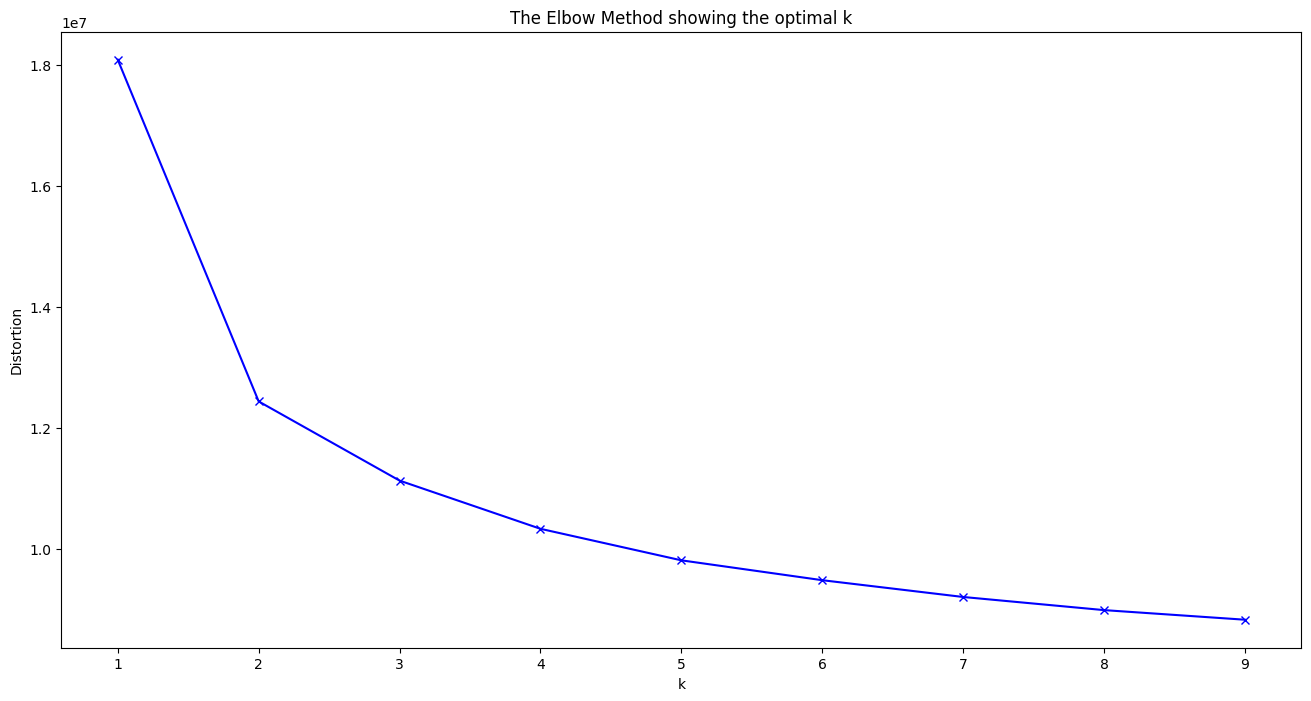

In [67]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-patt

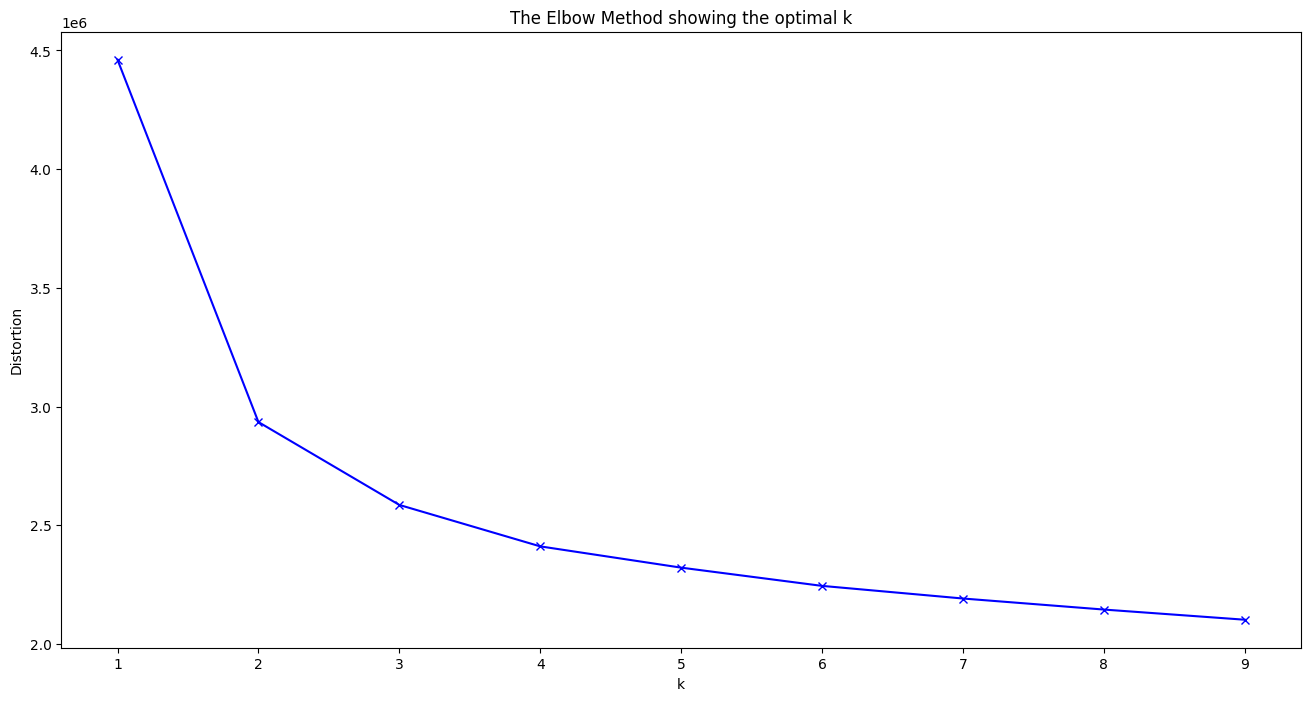

In [68]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [69]:
# ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.02618717 0.0154104 ]


In [71]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix.shape[0]))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,5.154606,-3.066806,4
1,-9.511904,-1.496878,0
2,-3.294545,0.047912,0
3,37.042071,-15.167695,3
4,-13.542178,31.232042,1
...,...,...,...
523,24.172969,8.080188,4
524,-0.729155,-4.877305,3
525,-11.973080,-1.355687,2
526,-11.176627,-7.807049,2


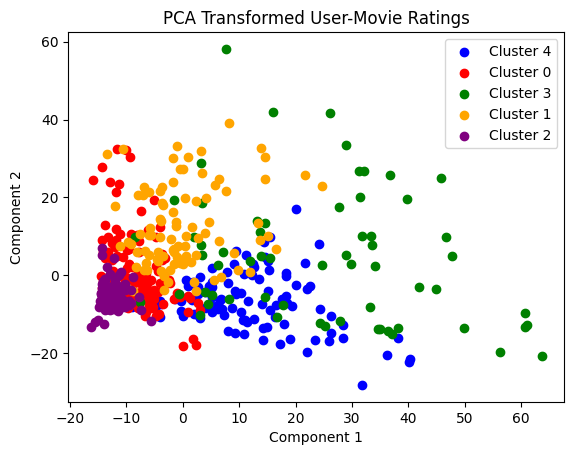

In [72]:
# create a scatter plot of the PCA components
fig, ax = plt.subplots()

for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    group = df_pca.groupby('Cluster').get_group(label)
    ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

# set the axis labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Transformed User-Movie Ratings')

# add a legend
ax.legend()

# show the plot
plt.show()

Να σχολιάσετε την αποτελεσματικότητα των συγκεκριμένων μετρικών στην αποτίμηση της ομοιότητας μεταξύ ενός ζεύγους διανυσμάτων προτιμήσεων χρηστών R_u και R_v.

Για την μετρική της ευκλείδιας απόστασης: 


*   Η ομοιότητα των χρηστών είναι **αντιστρόφως ανάλογη** της απόστασης μεταξύ τους.
*   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
*   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.


---


Για την μετρική του συνημιτόνου:


1.   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
2.   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.
3.   Η ομοιότητα των χρηστών μπορεί να υπολογιστεί στην περίπτωση που είναι η γωνία μεταξύ των διανυσμάτων τους από 0 - 90 ως ομοιότητα ενώ από 90 - 180 μπορούμε να εκφράσουμε την αντίθεση των χρηστών. Οπότε σε κάθε περίπτωση η μετρική μας βοηθά να ομαδοποιήσουμε τους χρήστες.





##JACCARD DISTANCE
Η απόσταση Jaccard απομετρά τη **διαφορετικότητα** μεταξύ δύο συνόλων (στην περίπτωσή μας δύο χρηστών). 



*   Στην περίπτωση που η τομή των δύο χρηστών γίνει μηδέν (δεν υπάρχουν δηλαδή κοινά αξιολογήσιμες ταινίες) η διαφορετικότητα των χρηστών παίρνει τη μέγιστη τιμή της, 1
*   Η διαφορετικότητα των χρηστών θα γίνει **ελάχιστη** όταν η *τομή* των δύο χρηστών είναι ίση με την *ένωσή* τους, όταν δηλαδή τα δύο σύνολα γίνουν *ίσα*
*   Μπορεί να χρησιμοποιηθεί για τη σύγκριση της ομοιότητας οποιουδήποτε είδους δεδομένων, συμπεριλαμβανομένων δεδομένων χρονοσειρών, φωτογραφιών, κειμένου και εικόνων.


---


Κάποια από τα μειονεκτήματα της ανωτέρω μετρικής είναι τα ακόλουθα:


---




*   **Απουσία "βαρών"**: Η απόσταση Jaccard εξετάζει μόνο την παρουσία ή την απουσία αξιολογήσεων για κάθε χρήστη και δεν λαμβάνει υπόψη τις πραγματικές τιμές αξιολόγησης. Μπορεί δηλαδή η *διαφορετικότητα*, η τιμή δηλαδή που θα προκύψει από την απόσταση Jaccard δύο χρηστών να είναι ελάχιστη, εάν έχουν αξιολογήσει τις ίδιες ταινίες ακόμα και αν ο ένας τις έχει αξιολογήσει με 5 και ο άλλος με 1.
*   **Αραιότητα αξιολογήσεων**: Για παράδειγμα, εάν δύο χρήστες έχουν αξιολογήσει μόνο έναν μικρό αριθμό ταινιών, είναι πιθανό να μην έχουν αξιολογήσει καμία από τις ίδιες ταινίες, άρα η τομή τους θα είναι μηδέν, με αποτέλεσμα η *διαφορετικότητά* τους να είναι μέγιστη, ακόμη και αν οι προτιμήσεις τους για τις ταινίες είναι στην πραγματικότητα αρκετά παρόμοιες. 




In [73]:
jaccard_dist = 1 - W
print(jaccard_dist)
jaccard_df = pd.DataFrame(jaccard_dist)
jaccard_df

def kmeans_clustering(jaccard_dist, k):
    # Initialize k-means object
    kmeans = KMeans(n_clusters=k)

    # Fit the k-means object to the Jaccard distance matrix
    kmeans.fit(jaccard_dist)

    return kmeans.labels_

labels = kmeans_clustering(jaccard_dist, 5)
print(labels)

[[0.         0.99017199 0.99354839 ... 1.         1.         0.95770393]
 [0.99017199 0.         0.9873817  ... 1.         1.         0.99145299]
 [0.99354839 0.9873817  0.         ... 1.         1.         0.99606299]
 ...
 [1.         1.         1.         ... 0.         1.         0.9486166 ]
 [1.         1.         1.         ... 1.         0.         1.        ]
 [0.95770393 0.99145299 0.99606299 ... 0.9486166  1.         0.        ]]


/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 1 3 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 0 2 3 3 3 1 1 1 1 3 0 0 1
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 3 1 0 1 1 1 3 0 2 0 3 1 1 3 1 4 0 1 3
 1 4 3 1 1 1 1 3 3 1 1 2 2 1 2 0 3 4 1 3 1 4 1 2 3 1 1 1 2 2 1 3 1 0 1 1 1
 1 2 1 0 1 1 2 1 1 1 1 1 3 1 4 0 2 2 0 0 1 4 4 1 1 0 0 1 1 3 0 2 0 1 3 2 1
 0 0 1 2 1 2 1 2 4 4 0 1 3 0 1 1 1 1 2 1 4 2 0 2 0 1 1 0 1 2 1 2 1 2 0 1 1
 1 1 4 1 2 1 2 3 0 1 2 4 2 1 0 0 1 1 1 1 2 0 4 4 2 3 2 3 1 1 0 0 1 1 0 0 3
 4 1 1 1 3 1 2 1 1 2 3 3 0 1 1 1 1 1 1 1 1 4 0 0 1 4 0 1 3 2 0 0 3 3 0 4 1
 1 1 1 1 2 1 1 1 1 0 4 3 4 1 0 1 1 1 2 1 2 1 1 2 0 2 4 1 0 1 1 1 1 4 2 1 1
 0 3 2 1 1 1 4 0 1 2 1 1 1 1 3 1 2 0 1 1 4 4 1 3 1 2 4 1 1 4 0 3 2 3 4 1 3
 0 1 1 2 1 1 2 2 4 1 1 2 1 1 2 1 2 1 2 1 3 1 1 1 2 1 1 2 1 1 3 1 1 2 4 0 1
 0 1 4 2 2 0 1 1 4 3 1 1 1 1 1 3 0 1 2 2 1 0 1 1 1 3 3 4 2 1 0 3 3 1 0 3 3
 2 0 2 1 0 4 3 0 1 4 0 3 1 0 2 0 1 3 2 4 1 1 3 1 1 4 1 1 0 1 1 2 1 1 3 0 0
 0 1 3 1 3 1 1 0 1 1 1 2 1 2 0 1 3 3 1 1 3 1 4 3 4 3 3 1 4 1 2 1 0 0 4 0 3
 1 0 0 3 0 1 3 3 3 3 0 3 

In [74]:
def plot_pca_cluster(ratings_matrix, n_clusters):
    # instantiate StandardScaler and PCA with 2 components for 2D scatter plot
    scaler = StandardScaler()
    pca = PCA(n_components=2)

    # fit and transform the ratings matrix
    ratings_pca = pca.fit_transform(ratings_matrix)

    # apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(ratings_matrix)

    # create a new dataframe with the PCA components and cluster labels
    df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix.shape[0]), columns=['Component 1', 'Component 2'])
    df_pca['Cluster'] = labels

    # create a scatter plot of the PCA components with color-coded clusters
    fig, ax = plt.subplots()

    for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
        group = df_pca.groupby('Cluster').get_group(label)
        ax.scatter(group['Component 1'], group['Component 2'], c=color, label=f'Cluster {label}')

    # set the axis labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title('PCA Transformed User-Movie Ratings')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()

/run/media/thanos/BAAE0E3FAE0DF523/SHARED/THANOS_PROJECTS/aics-pattern-recognition/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


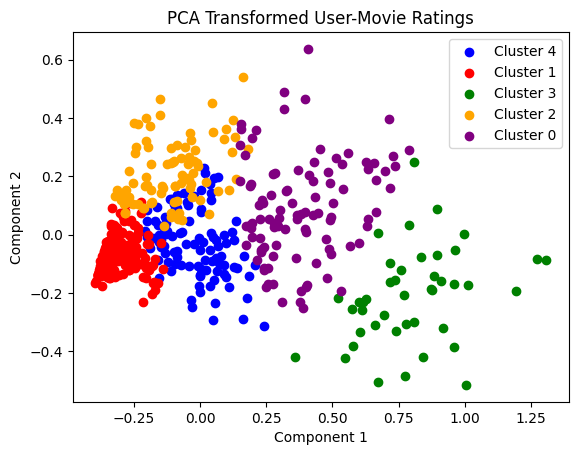

In [75]:
plot_pca_cluster(jaccard_dist, 5)

In [76]:
CommonRatings

array([[201.,   4.,   2., ...,   0.,   0.,  14.],
       [  4., 210.,   4., ...,   0.,   0.,   3.],
       [  2.,   4., 111., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ..., 122.,   0.,  13.],
       [  0.,   0.,   0., ...,   0., 109.,   0.],
       [ 14.,   3.,   1., ...,  13.,   0., 144.]])

# THANOS NEURAL NETWORK

In [77]:
# Define functions to create and train a linear regression model
from sklearn.model_selection import train_test_split


def create_nn_original_df(NEIGHBOURS, NEIGHBOURS_COLUMNS: list[str]):
    # create user_ratings_list
    user_index_list: list[int] = []
    user_ratings_list: list[int] = []
    for i in range(NEIGHBOURS.shape[0]):
        user_index_list.extend([i for ratings in ratings_matrix[i]])
        user_ratings_list.extend(ratings_matrix[i])
        
    # create neighbors list
    neighbors_list: list[list[int]] = []
    for i in range(NEIGHBOURS.shape[1]):
        neighbor_ratings_list: list[int] = []

        for j in range(NEIGHBOURS.shape[0]):
            neighbor = NEIGHBOURS[j][i]
            neighbor_ratings_list.extend(ratings_matrix[neighbor])

        neighbors_list.append(neighbor_ratings_list)


    nn_origin_df = pd.DataFrame()
    nn_origin_df['USER_INDEX'] = user_index_list
    nn_origin_df['USER_RATINGS'] = user_ratings_list

    for i in range(len(neighbors_list)):
        neighbor_ratings_list: list[int] = neighbors_list[i]
        nn_origin_df[NEIGHBOURS_COLUMNS[i]] = neighbor_ratings_list


    return nn_origin_df


def create_nn_filtered_normalized_df(ratings_normalize_factor, NEIGHBOURS, NEIGHBOURS_COLUMNS: list[str]):
    nn_origin_df = create_nn_original_df(NEIGHBOURS, NEIGHBOURS_COLUMNS)
    display('Dataframe with Original user ratings and neighbors ratings')
    display(nn_origin_df)
    display(nn_origin_df.describe())

    # create filtered dataframe

    nn_filtered_df = nn_origin_df.copy()[nn_origin_df['USER_RATINGS'] != 0]
    display('Dataframe with filter user ratings (non zero) and neighbors ratings')
    display(nn_filtered_df)
    display(nn_filtered_df.describe())

    nn_filtered_normalized_df = nn_filtered_df.copy()
    columns_to_normalize = ['USER_RATINGS']
    columns_to_normalize.extend(NEIGHBOURS_COLUMNS)
    nn_filtered_normalized_df[columns_to_normalize] = nn_filtered_normalized_df[columns_to_normalize] / ratings_normalize_factor
    display('Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating')
    display(nn_filtered_normalized_df)
    display(nn_filtered_normalized_df.describe())
    return nn_origin_df, nn_filtered_df, nn_filtered_normalized_df


def create_feature_columns(NEIGHBOURS_COLUMNS: list[str]):
    """Create feature columns"""
    feature_columns = []
    for column in NEIGHBOURS_COLUMNS:
        feature_columns.append(tf.feature_column.numeric_column(column))

    return feature_columns


def create_model(my_learning_rate, feature_columns):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    
    # Add the layer containing the feature columns to the model.
    model.add(tf.keras.layers.DenseFeatures(feature_columns))

    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                    name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=12, 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                    name='Hidden2'))

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                    loss="mean_squared_error",
                    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model           


def train_model(model: tf.keras.models.Sequential, train_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str], epochs: int, batch_size: int=1):
    """Train the model by feeding it data."""

    # Features as a dictionary with key the neighbor ratings column name and value an ndarray of the values
    features = {
        column: np.array(train_df[column]) for column in NEIGHBOURS_COLUMNS
    }
    label = np.array(train_df['USER_RATINGS'])
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]
    mae = hist["mean_absolute_error"]

    return epochs, mse, mae


def evaluate_model(model: tf.keras.models.Sequential, test_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str], batch_size: int=1):
    """Evaluate the model with the test_df"""

    # Features as a dictionary with key the neighbor ratings column name and value an ndarray of the values
    features = {
        column: np.array(test_df[column]) for column in NEIGHBOURS_COLUMNS
    }
    label = np.array(test_df['USER_RATINGS'])
    return model.evaluate(x = features, y = label, batch_size=batch_size)


def predict_model(model: tf.keras.models.Sequential, test_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str], batch_size: int=1):
    """Evaluate the model with the test_df"""

    # Features as a dictionary with key the neighbor ratings column name and value an ndarray of the values
    features = {
        column: np.array(test_df[column]) for column in NEIGHBOURS_COLUMNS
    }
    return model.predict(x = features, batch_size=batch_size)


def plot_the_loss_curve(epochs, mse_or_mae, is_mse: bool):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    ylabel = 'Train Mean Squared Error' if is_mse else 'Train Mean Absolute Error'
    plt.ylabel(ylabel)

    plt.plot(epochs, mse_or_mae, label="Loss")
    plt.legend()
    plt.ylim([mse_or_mae.min()*0.95, mse_or_mae.max() * 1.03])
    plt.show()



def calculate_real_mse_mae(origin_ratings: np_typing.NDArray, predictions: np_typing.NDArray):
    """Calculate the real mse and mae comparing real ratings and predictions."""

    n = 0
    absolute_sum = 0
    squared_sum = 0
    for i in range(origin_ratings.shape[0]):
        # take into consideration only non 0 ratings
        if origin_ratings[i] != 0.0:
            n += 1
            abs_value = abs(origin_ratings[i] - predictions[i])
            absolute_sum += abs_value
            squared_sum += math.sqrt(abs_value)

    
    mse = absolute_sum / n
    mae = squared_sum / n
    return mse, mae


def create_train_evaluate_neural_network(ratings_normalize_factor, nn_origin_df: pd.DataFrame, nn_filtered_normalized_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str]) -> tuple[float, float, float, float, float, float]:
    train_df, test_df = train_test_split(nn_filtered_normalized_df, test_size=0.2, random_state=42)
    train_df = pd.DataFrame(train_df)
    test_df = pd.DataFrame(test_df)

    display('traind_df', train_df)
    display('test_df', test_df)

    # The following variables are the hyperparameters.
    learning_rate = 0.01
    epochs = 32
    batch_size = 96

    # define the feature columns
    feature_columns = create_feature_columns(NEIGHBOURS_COLUMNS)
    # Establish the model's topography.
    my_model = create_model(learning_rate, feature_columns)

    # Train the model on the normalized training set.
    display('Training the model with the train_df')
    epochs, train_mse_series, train_mae_series = train_model(my_model, train_df, NEIGHBOURS_COLUMNS, epochs, batch_size)
    train_mse = train_mse_series.iloc[-1]
    train_mae = train_mae_series.iloc[-1]
    plot_the_loss_curve(epochs, train_mse_series, True)
    plot_the_loss_curve(epochs, train_mae_series, False)


    display('Evaluating the model against the test_df')
    test_loss, test_mse, test_mae = evaluate_model(my_model, test_df, NEIGHBOURS_COLUMNS, batch_size)
    display('test_loss, test_mse, test_mae', test_loss, test_mse, test_mae)

    predictions_normalized = predict_model(my_model, nn_origin_df, NEIGHBOURS_COLUMNS, batch_size)
    # turn list of sinle item lists to a sigle list with floats
    predictions_normalized = np.array([prediction_normalized[0] for prediction_normalized in predictions_normalized])
    predictions = predictions_normalized * ratings_normalize_factor
    display('predictions', predictions)
    display('predictions.shape', predictions.shape)

    real_ratings = nn_origin_df['USER_RATINGS'].to_numpy()
    display('real_ratings', real_ratings)
    real_mse, real_mae = calculate_real_mse_mae(real_ratings, predictions_normalized)
    display(f'real_mean_squared_error={real_mse}, real_mean_absolute_error={real_mae}')

    return train_mse, train_mae, test_mse, test_mae, real_mse, real_mae


'ratings_normalize_factor'

10.0

'NEIGHBOURS.shape'

(528, 5)

'NEIGHBOURS'

array([[4, 0, 0, 0, 2],
       [3, 4, 3, 4, 4],
       [0, 0, 4, 1, 2],
       ...,
       [3, 4, 2, 0, 1],
       [3, 4, 2, 3, 2],
       [0, 0, 1, 1, 4]])

'Dataframe with Original user ratings and neighbors ratings'

,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
278779,527,0.0,0.0,0.0,0.0,0.0,0.0
278780,527,0.0,0.0,0.0,0.0,0.0,0.0
278781,527,0.0,0.0,0.0,0.0,0.0,0.0
278782,527,0.0,0.0,0.0,0.0,0.0,0.0


,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
count,278784.000000,278784.000000,278784.000000,278784.000000,278784.000000,278784.000000,278784.000000
mean,263.500000,0.021651,0.025163,0.024786,0.024277,0.025604,0.024313
std,152.420471,0.405566,0.488463,0.483919,0.479193,0.491219,0.479243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,131.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,263.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,395.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,527.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'Dataframe with filter user ratings (non zero) and neighbors ratings'

,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
104,0,10.0,10.0,10.0,10.0,10.0,8.0
632,1,10.0,9.0,10.0,9.0,10.0,10.0
716,1,10.0,0.0,0.0,0.0,0.0,0.0
979,1,9.0,0.0,0.0,0.0,0.0,0.0
1160,2,8.0,10.0,10.0,10.0,10.0,8.0
...,...,...,...,...,...,...,...
277354,525,4.0,0.0,0.0,0.0,0.0,0.0
277585,525,8.0,0.0,0.0,0.0,0.0,0.0
277608,525,8.0,0.0,0.0,0.0,0.0,0.0
277767,526,10.0,0.0,0.0,0.0,0.0,0.0


,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,281.761960,7.043174,0.603267,0.680280,0.633606,0.701284,0.668611
std,147.141491,2.014377,2.333500,2.486035,2.403014,2.499423,2.446122
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,293.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,407.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,527.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
104,0,1.0,1.0,1.0,1.0,1.0,0.8
632,1,1.0,0.9,1.0,0.9,1.0,1.0
716,1,1.0,0.0,0.0,0.0,0.0,0.0
979,1,0.9,0.0,0.0,0.0,0.0,0.0
1160,2,0.8,1.0,1.0,1.0,1.0,0.8
...,...,...,...,...,...,...,...
277354,525,0.4,0.0,0.0,0.0,0.0,0.0
277585,525,0.8,0.0,0.0,0.0,0.0,0.0
277608,525,0.8,0.0,0.0,0.0,0.0,0.0
277767,526,1.0,0.0,0.0,0.0,0.0,0.0


,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
count,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000,857.000000
mean,281.761960,0.704317,0.060327,0.068028,0.063361,0.070128,0.066861
std,147.141491,0.201438,0.233350,0.248603,0.240301,0.249942,0.244612
min,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,293.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,407.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000
max,527.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'traind_df'

,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
2744,5,0.8,1.0,0.8,1.0,0.8,0.8
78382,148,0.5,0.0,0.0,0.0,0.0,0.0
66716,126,0.8,0.0,0.0,1.0,1.0,0.0
119566,226,1.0,0.0,0.0,0.0,0.0,0.0
43562,82,0.8,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
30812,58,0.1,0.0,0.0,1.0,0.0,1.0
46202,87,0.9,0.0,0.0,0.0,0.0,0.0
103198,195,0.6,0.0,0.0,0.0,0.0,0.0
157532,298,0.3,1.0,0.0,0.0,0.0,0.0


'test_df'

,USER_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4
231980,439,0.7,0.0,0.0,0.0,0.0,0.0
204725,387,1.0,0.0,0.0,0.0,0.0,0.0
51932,98,0.7,0.0,0.0,0.0,0.0,1.0
83048,157,0.1,0.0,0.0,0.0,0.0,0.0
139102,263,0.9,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
189414,358,0.6,0.0,0.0,0.0,0.0,0.0
89948,170,0.8,0.0,1.0,0.0,0.0,0.0
123262,233,0.7,0.0,0.0,0.0,0.0,0.0
84140,159,0.3,0.0,0.0,0.0,0.0,0.0


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


'Training the model with the train_df'

Epoch 1/32
8/8 [==============================] - 0s 1ms/step - loss: 1.1204 - mean_squared_error: 0.4086 - mean_absolute_error: 0.6053
Epoch 2/32
8/8 [==============================] - 0s 840us/step - loss: 0.5083 - mean_squared_error: 0.1126 - mean_absolute_error: 0.2790
Epoch 3/32
8/8 [==============================] - 0s 787us/step - loss: 0.2599 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1841
Epoch 4/32
8/8 [==============================] - 0s 821us/step - loss: 0.1366 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1703
Epoch 5/32
8/8 [==============================] - 0s 858us/step - loss: 0.0810 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1643
Epoch 6/32
8/8 [==============================] - 0s 931us/step - loss: 0.0569 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1606
Epoch 7/32
8/8 [==============================] - 0s 800us/step - loss: 0.0463 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1579
Epoch 8/32
8/8 [====================

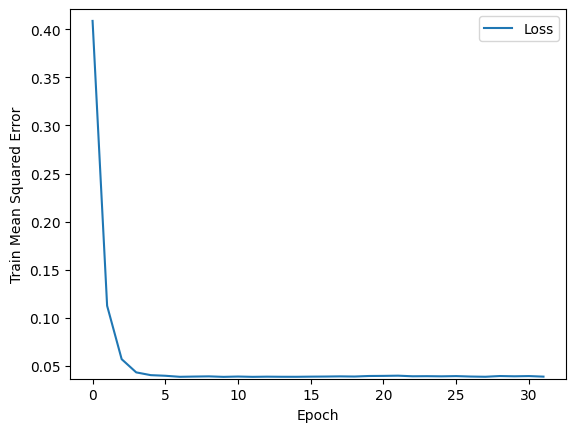

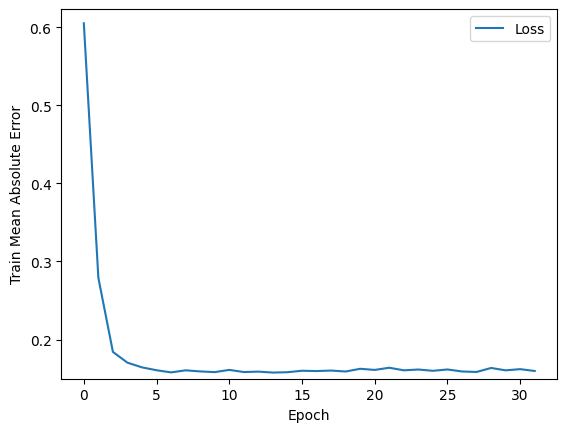

'Evaluating the model against the test_df'

2/2 [==============================] - 0s 2ms/step - loss: 0.0475 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1728


'test_loss, test_mse, test_mae'

0.04745998978614807

0.04744911193847656

0.17279775440692902

2904/2904 [==============================] - 1s 453us/step


'predictions'

array([7.1008263, 7.1008263, 7.1008263, ..., 7.1008263, 7.1008263,
       7.1008263], dtype=float32)

'predictions.shape'

(278784,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=6.333122008809409, real_mean_absolute_error=2.47539288596397'

'results_df'

,TRAIN_MSE,TRAIN_MAE,TEST_MSE,TEST_MAE,REAL_MSE,REAL_MAE
CLUSTER_0,0.038954,0.159698,0.047449,0.172798,6.333122,2.475393


In [78]:
# THANOS NEURAL NETWORK

n_clusters = 5
k = 5
ratings_normalize_factor: float = ratings_matrix.max().max()

NEIGHBOURS = np.array([
    [np.random.randint(low=0, high=k) for j in range(k)] for u in range(CommonRatings.shape[0])
])
display('ratings_normalize_factor', ratings_normalize_factor)
display('NEIGHBOURS.shape', NEIGHBOURS.shape)
display('NEIGHBOURS', NEIGHBOURS)

# Create, train and evaluate a Neural Network for each cluster

NEIGHBOURS_COLUMNS = [f'NEIGHBOR_RATINGS_{i}' for i in range(k)]
results: list[list[float]] = []
results_df_index: list[str] = []

for cluster_index in range(1):
    nn_origin_df, nn_filtered_df, nn_filtered_normalized_df = create_nn_filtered_normalized_df(
        ratings_normalize_factor, NEIGHBOURS, NEIGHBOURS_COLUMNS)

    train_mse, train_mae, test_mse, test_mae, real_mse, real_mae = create_train_evaluate_neural_network(
        ratings_normalize_factor, nn_origin_df, nn_filtered_normalized_df, NEIGHBOURS_COLUMNS)
    results.append([train_mse, train_mae, test_mse,
                   test_mae, real_mse, real_mae])
    results_df_index.append(f'CLUSTER_{cluster_index}')


results_df_columns = ['TRAIN_MSE', 'TRAIN_MAE',
                      'TEST_MSE', 'TEST_MAE', 'REAL_MSE', 'REAL_MAE']
results_df = pd.DataFrame(
    results, columns=results_df_columns, index=results_df_index)
display('results_df', results_df)
